部分代码参考自知乎文章：[利用500W条微博语料对评论进行情感分析](https://zhuanlan.zhihu.com/p/30061051),语料库见文章内分享链接

In [2]:
import mysql.connector

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd="yourpassword",
  database="TEST"
)

In [4]:
mycursor = mydb.cursor()
mycursor.execute(" delete from weibo where text=NULL")


In [5]:
mycursor = mydb.cursor()
mycursor.execute(" delete from weibo where text='Repost'")

In [6]:
mycursor = mydb.cursor()
mycursor.execute(" delete from weibo where text=''")

In [1]:
# 导入所需的库
import re
from snownlp import sentiment
import numpy as np
import pandas as pd
import pymysql
from snownlp import SnowNLP
from snownlp import sentiment
from snownlp.sentiment import Sentiment
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.style.use('ggplot')

In [9]:
conn = pymysql.connect(host='localhost', user='root', password='yourpassword', charset="utf8",use_unicode=False)  # 连接服务器
with conn:
    cur = conn.cursor()
    cur.execute("SELECT * FROM test.weibo WHERE weiboId < '%d'" % 6000000)
    rows = cur.fetchall()


In [10]:
comment = []
for row in rows:
    row = list(row)
    comment.append(row[18])


In [2]:

# 按文章的说法，初步筛选语料，大于0.8的归入积极，小于0.3的归入消极。
def train_model(texts):
    for li in tqdm(texts):
        comm = li.decode('utf-8')
        text = re.sub(r'(?:回复)?(?://)?@[\w\u2E80-\u9FFF]+:?|\[\w+\]', ',',comm)
        score = SnowNLP(text)
        if score.sentiments > 0.8:
            with open('pos.txt', mode='a', encoding='utf-8') as g:
                g.writelines(comm +"\n")
        elif score.sentiments < 0.3:
            with open('neg.txt', mode='a', encoding='utf-8') as f:
                f.writelines(comm + "\n")
        else:
            pass

In [12]:
%%time
train_model(comment)


Wall time: 17h 25min 2s


In [14]:
%%time
# 将上面筛选出的语料重新进行训练，

sentiment.train('neg.txt', 'pos.txt')
 

Wall time: 12h 46min 51s


In [15]:
sentiment.save('sentiment.marshal')    # 保存新模型后替换默认模型或者讲路径指向新模型。

In [64]:
# 中文语料库训练出来很奇怪，名字也带有情感，整体情绪偏积极
li = '六小龄童'
text = re.sub(r'(?:回复)?(?://)?@[\w\u2E80-\u9FFF]+:?|\[\w+\]', '',li)
print(text)
s = SnowNLP(text)
print(s.sentiments)

六小龄童
0.8781921115138102


### 模型训练完成，导入自己爬的微博数据

In [92]:
# 选取了北京重度雾霾的三天作为分析数据
comment = pd.read_csv('comment20180731_0802.csv', encoding='utf-8')
tweet = pd.read_csv('tweet20180731_0802.csv', encoding='utf-8')

# 标记出发自北京的评论
comment['merge_id'] = comment['weibo_id']
tweet['merge_id'] = tweet['_id']
merge = comment.merge(tweet, on='merge_id')
merge['is_beijing'] = merge['province'].map(lambda x: 1 if x == '北京' else 0)

# 计算评论发出的时间距离微博发出的时间间隔
merge['comment_time'] = merge['created_at_x'].map(lambda x: datetime.datetime(int(x[0:4]),int(x[5:7]),int(x[8:10]),int(x[11:13]),int(x[14:16])))
merge['weibo_time'] = merge['created_at_y'].map(lambda x: datetime.datetime(int(x[0:4]),int(x[5:7]),int(x[8:10]),int(x[11:13]),int(x[14:16])))
merge['time_interval'] = merge['comment_time'] - merge['weibo_time']

# 选择微博发出3天内的用户评论
merge['day3'] = merge['time_interval'].map(lambda x: 1 if x.days<3 else 0)
day3 = merge[merge['day3']==1]

In [77]:
merge.head()

,_id_x,weibo_id,comment_user_id,created_at_x,content_x,like_num_x,crawl_time_x,province,city,merge_id,...,created_at_y,like_num_y,repost_num,comment_num,content_y,is_beijing,comment_time,weibo_time,time_interval,day3
0,C_4312383817875910,2769897145_H5c8SjzsG,5347302211,2018-12-01 11:44:45,ppt,2,1551036368,山东,NaN,2769897145_H5c8SjzsG,...,2018-12-01 11:42:14,72,6,21,2018.12.1 雷霆VS老鹰 全场高清视频集锦。雷霆喜迎2连胜，43.9%的三分命中率命...,0,2018-12-01 11:44:00,2018-12-01 11:42:00,00:02:00,1
1,C_4312383977227063,2769897145_H5c8SjzsG,5873610688,2018-12-01 11:45:22,冲鸭,1,1551036368,其他,NaN,2769897145_H5c8SjzsG,...,2018-12-01 11:42:14,72,6,21,2018.12.1 雷霆VS老鹰 全场高清视频集锦。雷霆喜迎2连胜，43.9%的三分命中率命...,0,2018-12-01 11:45:00,2018-12-01 11:42:00,00:03:00,1
2,C_4312384254371170,2769897145_H5c8SjzsG,6520365853,2018-12-01 11:46:29,威少今天应该又是三双吧？,1,1551036368,广东,NaN,2769897145_H5c8SjzsG,...,2018-12-01 11:42:14,72,6,21,2018.12.1 雷霆VS老鹰 全场高清视频集锦。雷霆喜迎2连胜，43.9%的三分命中率命...,0,2018-12-01 11:46:00,2018-12-01 11:42:00,00:04:00,1
3,C_4312385990533122,2769897145_H5c8SjzsG,6111811717,2018-12-01 11:53:23,差一个篮板好可惜,0,1551036368,其他,NaN,2769897145_H5c8SjzsG,...,2018-12-01 11:42:14,72,6,21,2018.12.1 雷霆VS老鹰 全场高清视频集锦。雷霆喜迎2连胜，43.9%的三分命中率命...,0,2018-12-01 11:53:00,2018-12-01 11:42:00,00:11:00,1
4,C_4312387069145212,2769897145_H5c8SjzsG,6077850447,2018-12-01 11:57:39,雷霆总冠军,0,1551036368,四川,成都,2769897145_H5c8SjzsG,...,2018-12-01 11:42:14,72,6,21,2018.12.1 雷霆VS老鹰 全场高清视频集锦。雷霆喜迎2连胜，43.9%的三分命中率命...,0,2018-12-01 11:57:00,2018-12-01 11:42:00,00:15:00,1


In [118]:
# 定义一个函数计算评论的情绪分数

def snowanalysis(self):
    try:
        num = len(self)
    except:
        num = self.size
        
    sentimentslist = []
    for i in range(num):
        li = self[i]
        if li:   # 有些是空白评论，需要跳过     
            # 正则表达式替换掉回复评论的开头“回复@……”
            li = str(li)  # 统一转为字符串避免报错
            
            if li != 'nan':    # 存在一部分的空白评论
                text = re.sub(r'(?:回复)?(?://)?@[\w\u2E80-\u9FFF]+:?|\[\w+\]', '', li)
                # 中英文标点符号似乎带有情感，全部替换掉
                r='[’！？：；【】，《》!"#$%&\'()（）“”…*+,-./:;<=>?@[\\]^_`{|}~]+'
                text = re.sub(r, '', text)
                # 给该条评论打分
                if text:
                    s = SnowNLP(text)
#                     # 看看预测为中性的评论内容
#                     if 0.45 < s.sentiments < 0.55:
#                         print(text)
#                         print('情绪分数：', s.sentiments)

                    # 为了做频率直方图，把分数保存在numpy数组里
                    sentimentslist.append(s.sentiments)
                    score = np.array(sentimentslist)
    
    # 对分值进行归一化（尝试修正模型的偏移，非必须）
    #score = score*0.5/0.7244678128321579
    #score = (score - score.min()) / (score.max() - score.min())
    
    plt.subplot(121)
    plt.hist(score, bins=np.arange(0, 1, 0.02), density=True)
    plt.subplot(122)
    plt.boxplot(score)
    plt.show()
    # 返回分值的列表
    return score

In [93]:
comment_bj = list(merge['content_x'][merge['is_beijing'] == 1])

In [76]:
merge['no_haze'] = merge['province'].map(lambda x: 1 if x not in ['北京','其他','海外','河北'] else 0)
comment_gd = list(merge['content_x'][merge['no_haze']==1])

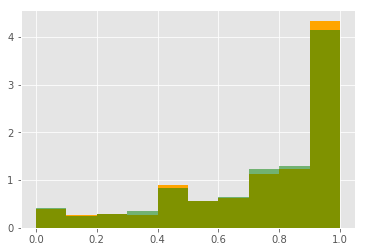

In [89]:
plt.hist(bj, density=True, bins=np.arange(0, 1.01, 0.1), color='orange')
plt.hist(gd, density=True, bins=np.arange(0, 1.01, 0.1), color='green', alpha = 0.5)
plt.show()

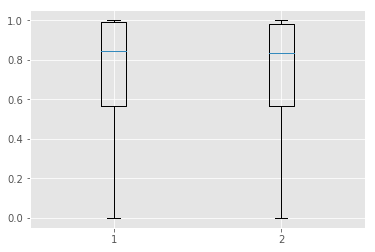

In [80]:
plt.boxplot([bj, gd])
plt.show()

In [105]:
comment = pd.read_csv('comment20181201_03.csv', encoding='utf-8')
tweet = pd.read_csv('tweet20181201_03.csv', encoding='utf-8')

comment['merge_id'] = comment['weibo_id']
tweet['merge_id'] = tweet['_id']
merge = comment.merge(tweet, on='merge_id')
merge['is_beijing'] = merge['province'].map(lambda x: 1 if x == '北京' else 0)

In [106]:
s = SnowNLP('回复@_你要梦什么:事情发生在东北，就有很多人说东北这个那个的，真是无语的地域黑。还有钱外露，钱放在自己家里露给你看的啊？')
s.sentiments

0.06965724902850201

In [110]:
comment_bj = list(day3['content_x'][day3['is_beijing'] == 1])
comment_gd = list(day3['content_x'][day3['province'] == '广东'])
comment_sh = list(day3['content_x'][day3['province'] == '上海'])

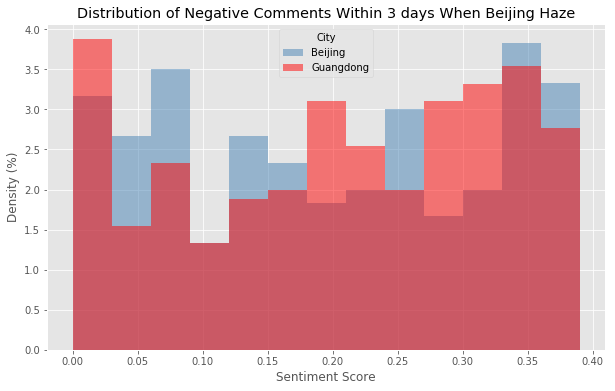

In [124]:
plt.figure(figsize=(10,6))
p1 = plt.hist(bj, density=True, bins=np.arange(0, 0.4, 0.03), color='steelblue', alpha =0.5)
p2 = plt.hist(gd, density=True, bins=np.arange(0, 0.4, 0.03), color='red', alpha = 0.5)
plt.title('Distribution of Negative Comments Within 3 days When Beijing Haze')
plt.xlabel('Sentiment Score')
plt.ylabel('Density (%)')
plt.legend(['Beijing', 'Guangdong'], title='City')
plt.savefig('p1.png')
plt.show()

在小于0.2的区间里北京的占比要多一些，似乎更偏激的消极评论更容易出现。

易烊千玺吖
情绪分数： 0.5466165329737394
马蓉还有超话。哈哈
情绪分数： 0.4737672181921908
Emmm
情绪分数： 0.5
真的非常牛逼这个大姐
情绪分数： 0.45192593495698663
自编自导自演厉害了我的姐
情绪分数： 0.5027751325727445
 
情绪分数： 0.5262327818078083
能啊
情绪分数： 0.5262327818078083
卸了没什么用
情绪分数： 0.4537736930444728
我还以为是我手机有问题不支持这个软件原来如此
情绪分数： 0.462755022585275
人家只是在做自己他活的坦坦荡荡。
情绪分数： 0.5084838970607746
为什么觉得他说话时候的动作神态好像金星啊
情绪分数： 0.5417920429155534
差不多就是年过半百了
情绪分数： 0.4538681162280954
对
情绪分数： 0.5262327818078083
nc
情绪分数： 0.5
哪里diss别人了
情绪分数： 0.5013490597296458
呸
情绪分数： 0.5262327818078083
不是打黑工的应该是溜了
情绪分数： 0.45381471560901976
牧羊犬警告和你更配哦
情绪分数： 0.521787401102477
1126事变
情绪分数： 0.4737672181921908
当你拿得起
情绪分数： 0.5262327818078083
我也
情绪分数： 0.5262327818078083
假的
情绪分数： 0.5
我的电动车叫小白玻尿酸鸭玩偶叫黄胖一个靠枕叫snake
情绪分数： 0.49247269928402937
小猪猪
情绪分数： 0.5025370734601784
 
情绪分数： 0.5262327818078083
好暖
情绪分数： 0.5
崩坏的世界线
情绪分数： 0.4737672181921908
哈哈
情绪分数： 0.5262327818078083
我相信
情绪分数： 0.5262327818078083
好好听啊
情绪分数： 0.46175896454978704
我相信
情绪分数： 0.5262327818078083
精忠报国和我相信都太好听了
情绪分数： 0.5108792541690

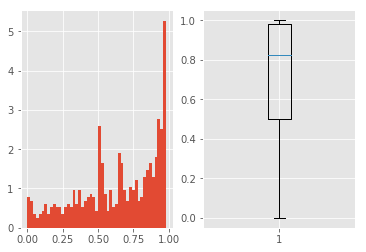

In [120]:
sh = snowanalysis(comment_sh)

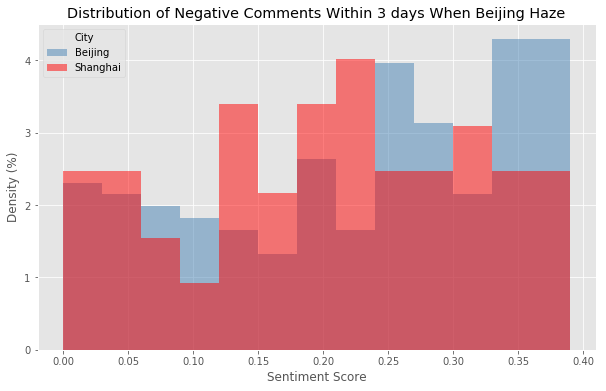

In [101]:
plt.figure(figsize=(10,6))
p1 = plt.hist(bj, density=True, bins=np.arange(0, 0.4, 0.03), color='steelblue', alpha =0.5)
p2 = plt.hist(sh, density=True, bins=np.arange(0, 0.4, 0.03), color='red', alpha = 0.5)
plt.title('Distribution of Negative Comments Within 3 days When Beijing Haze')
plt.xlabel('Sentiment Score')
plt.ylabel('Density (%)')
plt.legend(['Beijing', 'Shanghai'], title='City')
plt.savefig('p2.png')
plt.show()

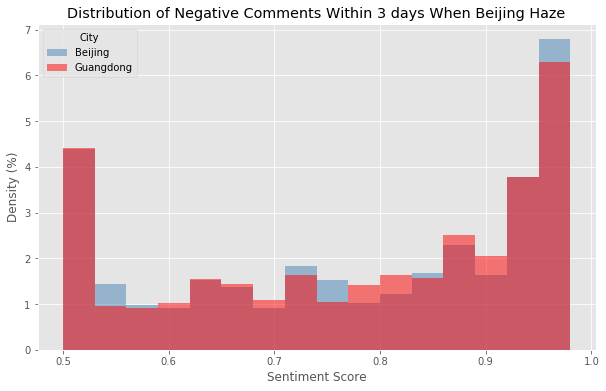

In [123]:
plt.figure(figsize=(10,6))
p1 = plt.hist(bj, density=True, bins=np.arange(0.5, 1.0, 0.03), color='steelblue', alpha =0.5)
p2 = plt.hist(gd, density=True, bins=np.arange(0.5, 1.0, 0.03), color='red', alpha = 0.5)
plt.title('Distribution of Negative Comments Within 3 days When Beijing Haze')
plt.xlabel('Sentiment Score')
plt.ylabel('Density (%)')
plt.legend(['Beijing', 'Guangdong'], title='City')
plt.savefig('p2.png')
plt.show()

基于训练好的模型（建议训练一个靠谱的模型为优先，如果有足够的标注样本做深度学习模型是最好的。）和抓取的微博评论，可以进行多方面的分析，限于项目时间暂时到此，欢迎提出想法和意见。